#  Activity 1.1: $k$-Nearest Neighbour Classifier
Last modified (11 Aug 2023)

### Learning outcomes

In this activity, we learn how to:

- load and visualise an example dataset via `scikit-learn` and `matplotlib`
- split a dataset into train and test set (using `numpy`)
- use the `scikit-learn` conventions to call (and implement) a machine learning algorihtm
- describe and implement the $k$-NN classifier 
- compute error rate and confusion matrix for prediction results
- plot the effect of the hyper-parameter $k$ on train and test error (using `matplotlib`)

### Prerequisites

- Lecture 1
- Basic Python and numpy

## Introduction

In this activity, we learn how <a href="https://saravananthirumuruganathan.wordpress.com/2010/05/17/a-detailed-introduction-to-k-nearest-neighbor-knn-algorithm/">K-Nearest Neighbors (KNN)</a> classifier works, which we will use as a vehicle to practice some of the basic concepts of machine learning. KNN is a "non-parametric" model, which means that the number of estimated parameters grows with the number of training data points (as opposed to parametric models where the number of parameters is fixed based based on the dimensionality of the input data). 

In particular, KNN is an example of an <a href="https://en.wikipedia.org/wiki/Instance-based_learning">instance-based</a> supervised learner and a <a href="https://en.wikipedia.org/wiki/Lazy_learning">lazy learner</a> that stores all training data points and their labels in memory, and predict the class label for a new data point based on its similarity to the training data.
The labels of the stored training data points are considered the parameters of the model.

Consider a training dataset containing $(x_1,t_1), \dots, (x_N,t_N)$ pairs where $x_N \in \mathbb{R}^p$ is the input and $t_N \in \mathcal{C}$ is the target class label. Given a test data point $x_0$, the $k$-nearest neighbour classifier works as follows:

1. Select the $k$ data points from the training data that are *nearest* to $x_0$, where we assess closeness/distance by some distance measure, per default the usual Eucledian distance $\|x_n-x_0\|$
2. Look at the label of the $k$ nearest neighbours and select the label which has the majority vote

If the classes are equally common among the neighbours (e.g., two positive and two negative neighbours in binary classification when K=4), the test datapoint is randomly assigned to one of the classes. For example, Figure <strong>A.1</strong> (below) illustrates such situation where the test datapoint (shown by <span style="color: #00ff00;">green</span>) has exactly two neighbours from each class (marked by <span style="color: #ff0000;">red</span> and <span style="color: #3366ff;">blue</span>).

<a href="http://www.saedsayad.com/k_nearest_neighbors.htm" rel="attachment wp-att-92100"><img class="wp-image-92100 size-full" src="http://www.saedsayad.com/images/KNN_example_1.png" alt="Figure A.1: KNN for Classification. The green dot indicates a sample with an unknown class label, while red and blue samples are training observation from default and non-default classes, respectively. Source: http://www.saedsayad.com/k_nearest_neighbors.htm" width="497" height="274" /></a> 

> Figure A.1: KNN for Classification. The green dot indicates a sample with an unknown class label, while red and blue samples are training observation from default and non-default classes, respectively. Source: http://www.saedsayad.com/k_nearest_neighbors.htm

### Further Materials
This short <a href="https://www.youtube.com/watch?v=UqYde-LULfs">YouTube video</a> explains KNN and related concepts in a very simple language.

### Outline

Here, we implement a basic KNN classifier. Note that in Assignment 1, you will be asked to expand this implementation and build a KNN regressor. In this task, we use a simple, yet very popular, dataset to investigate the performance of our KNN. 

- Load the iris dataset and divide it to separate training and testing sets,
- Define a function that calculates the majority vote,
- Define KNN function that takes training labeled samples, testing samples, $K$ and a distance metric and predicts the class labels for the testing samples,
- Apply KNN where for some values of $K$ and report training and testing error
- Plot training and testing error versus $1/K$ where $K \in \{1,\cdots,100\}$

## Loading and Visualising the Data

We will use `scikit-learn` to load an example dataset that is quite famous in machine learning and statistics: the [Iris flower dataset](https://en.wikipedia.org/wiki/Iris_flower_data_set) that has been published by the famous statistician Ronald Fisher in 1936. Then we will use `matplotlib` to visualise the data as two scatter plots, which is possible because the data only has four input variables.

The example datasets in `scikit-learn` can be loaded via the functions in the module `sklearn.datasets` (see also [here](https://scikit-learn.org/stable/datasets.html)). Specifically, the functions return `bunch` objects that are dict-like objects containing among others the key/values:

- `'data'`: the $n$-times-$p$ matrix of input (feature) values 
- `'target'`: the $n$-vector of labels (target values) coded numerically
- `'feature_names`: the names of the input variables
- `'target_names'`: the names of the target classes (corresponding to the numerical codes)

In [1]:
from sklearn.datasets import load_iris

iris = load_iris()
iris.data.shape, iris.target.shape, iris.feature_names, iris.target_names

((150, 4),
 (150,),
 ['sepal length (cm)',
  'sepal width (cm)',
  'petal length (cm)',
  'petal width (cm)'],
 array(['setosa', 'versicolor', 'virginica'], dtype='<U10'))

In [2]:
iris.data[:10]

array([[5.1, 3.5, 1.4, 0.2],
       [4.9, 3. , 1.4, 0.2],
       [4.7, 3.2, 1.3, 0.2],
       [4.6, 3.1, 1.5, 0.2],
       [5. , 3.6, 1.4, 0.2],
       [5.4, 3.9, 1.7, 0.4],
       [4.6, 3.4, 1.4, 0.3],
       [5. , 3.4, 1.5, 0.2],
       [4.4, 2.9, 1.4, 0.2],
       [4.9, 3.1, 1.5, 0.1]])

In [3]:
iris.target

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

Next we plot this data using scatter plots via `matplotlib`. See how we can use `numpy` fancy indexing to select sub-portions of the data that belong to certain target values.

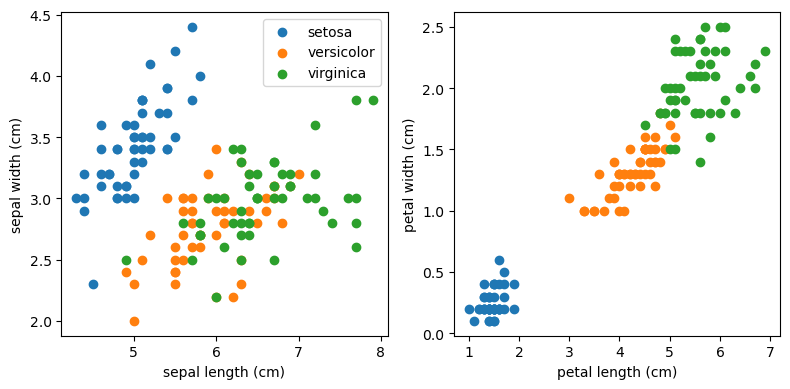

In [4]:
from matplotlib import pyplot as plt

def plot_scatter_by_label(bunch, x=0, y=1, ax=None, legend=False):
    ax = plt.gca() if ax is None else ax
    for i, name in enumerate(bunch.target_names):
        ax.scatter(bunch.data[bunch.target == i, x], bunch.data[bunch.target == i, y], label=name)
        ax.set_xlabel(bunch.feature_names[x])
        ax.set_ylabel(bunch.feature_names[y])
    if legend: ax.legend()

_, axs = plt.subplots(1, 2, figsize=(8, 4), tight_layout=True)
plot_scatter_by_label(iris, 0, 1, ax=axs[0], legend=True)
plot_scatter_by_label(iris, 2, 3, ax=axs[1])
plt.show()

## Splitting the Data into Train and Test Set

A crucial step for evaluating machine learning algorithms is to split the available data into a train and a test set. In `scikit-learn` we can use the function [`model_selection.train_test_split`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) for that step. In the future you will likely resort to importing that function when you want to perform a training/test split. Just for this time, let us re-implement the function to practice numpy and to prepare ourselves for the situation when we would like to implement more complicated splitting schemes (like in the next activity).

#### Task A: Why to split?

**Explain in two to three sentences, what is the purpose of splitting the data into training and test sets and why is it important?**

Seperating training and test sets allows the model to be evaluated on unseen data which is important since it helps to prevent overfitting situations

#### Task B: How to split?

**Finish the implementation of the below function by adding a return statement**

Hint: remember how we can use indexing with numpy arrays to select a subset of array elements.

In [5]:
import numpy as np

def train_test_split(x, y, train_size=0.6, random_state=None):
    RNG = np.random.default_rng(random_state)
    N = len(x)
    N_train = round(N*train_size)
    idx_train = RNG.choice(N, N_train, replace=False)
    idx_test = np.setdiff1d(np.arange(N), idx_train)
    RNG.shuffle(idx_test)
    # YOUR CODE HERE
    x_train = x[idx_train]
    y_train = y[idx_train]
    x_test = x[idx_test]
    y_test = y[idx_test]
    return x_train, x_test, y_train, y_test
    

x_train, x_test, y_train, y_test = train_test_split(iris.data, iris.target, train_size=0.6, random_state=1)

## Implementing $k$-NN 

Now we can go ahead and implement the $k$-NN classifier. For that we will follow the conventations of `scikit-learn` "estimators" (objects that allow us to estimate certain quantities from data). In `scikit-learn`, users interact with estimators in three steps:

1. **Define:** set all hyper-parameters through the object's initialiser (as defined in the `__init__` method)
2. **Fit:** fit (or train) the model using a training dataset through the estimator's `fit` method
3. **Predict:** use the estimator to predict unknwon quantities for new data throught the estimator's `predict` method

Below is an almost complete implementation of these three steps for the $k$-NN classifier:

- The `__init__` method simply sets the hyper-parameter $k$.
- The `fit` method also does not have to do much: As $k$-NN is a lazy learner it simply stores the training data to work with it later at prediction time. In this case, the input variables of the training data are stored in a special data structure called kd-tree that, the implementation of which we are taking from the `scipy` library. You can find further information [here](https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.KDTree.html), but all we need to know about this data structure at this point is that it makes determining the nearest neighbours of a datapoint very efficient.
- In the `predict` method we can see how the kd-tree is used to find the $k$-nearest neighbour matrix for the given data. This matrix is given as a `numpy.ndarray` of shape `(m, k)` when predicting the label for `m` datapoints, and it contains in row $i$ the indices of the $k$ nearest neighbours in the training data of the $i$-th test point.

#### Task C: Finish the Implementation of Predict

Hint: The part that finds the nearest neighbours for all given test data points is already implemented. Similarly, the last two rows already contain the code for computing (using [`scipy.stats.mode`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.mode.html)) and returning the majority target values among the target values of those neighbours. Thus, it only remains to retrieve the stored training labels for those neighbours. How can you do that with array indexing?

In [13]:
from scipy.spatial import KDTree
from scipy.stats import mode

class KnnClassifier:

    def __init__(self, k):
        self.k = k

    def fit(self, x, y):
        self.y_train_ = y
        self.x_train_kdtree_ = KDTree(x)
        return self

    def predict(self, x):
        _, neighbours = self.x_train_kdtree_.query(x, k=self.k)
        neighbours = neighbours.reshape(len(x), self.k)
        neighbour_labels = self.y_train_[neighbours]
        m, _ = mode(neighbour_labels, axis=1, keepdims=False)
        return m


#### Task D: Apply $k$-NN to Predict Iris Species

**Use our above implementation to predict the iris species of the test set after fitting the model on the training set. Store the predictions as `y_hat_test`.**

Hint: recall the three steps define, fit, predict. Use some "reasonable" for $k$, e.g., $k=4$.


In [12]:
knn = KnnClassifier(4)
knn.fit(x_train,y_train)
y_hat_test = knn.predict(x_test)


ModeResult(mode=array([2, 2, 2, 1, 1, 2, 1, 2, 1, 1, 0, 1, 1, 0, 2, 2, 1, 1, 2, 2, 0, 1,
       2, 0, 1, 0, 1, 1, 0, 1, 2, 0, 0, 1, 1, 0, 2, 2, 0, 0, 0, 2, 0, 2,
       0, 0, 0, 2, 2, 1, 2, 0, 1, 2, 2, 0, 0, 0, 2, 1], dtype=int64), count=array([4, 4, 4, 4, 2, 4, 4, 4, 4, 4, 4, 3, 2, 4, 4, 3, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 2, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 3, 4, 2, 4, 4, 2, 4, 4, 4, 4, 4, 4, 4], dtype=int64))


#### Task E: Determining the Error Rate

**Add one line in the code below to complete the implementation of the function `error_rate`.**

As a reminder: For predictions $\hat{y}$ of true labels $y$, we define the 0-1 error (also *error rate*) of the classifier as the fraction of misclassified examples, i.e., for $n$ examples, we define

\begin{equation*}
e(y, \hat{y}) = \sum_{i=1}^n \delta_{(y_i\neq \hat{y}_i)}
\end{equation*}
where
\begin{equation*}
\delta_{(y_i\neq \hat{y}_i)}=
\begin{cases}
0 &, \text{ if } y_i = \hat{y}_i\\
1 &, \text{ otherwise}
\end{cases}\enspace .
\end{equation*}



In [8]:
def error_rate(y, y_hat):
    n = len(y)
    sum_of_errors = np.sum(y != y_hat)
    return sum_of_errors/n

y_hat_train = knn.predict(x_train)
error_rate(y_train, y_hat_train), error_rate(y_test, y_hat_test)

(0.022222222222222223, 0.06666666666666667)

A more detailed summary of our prediction results is provided by a confusion matrix, which shows the distribution of predictions per true label. We can use `scikit-learn` to both, compute and conveniently plot, a confusion matrix.

In [69]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_hat_test)
cm

array([[20,  0,  0],
       [ 0, 16,  1],
       [ 0,  3, 20]], dtype=int64)

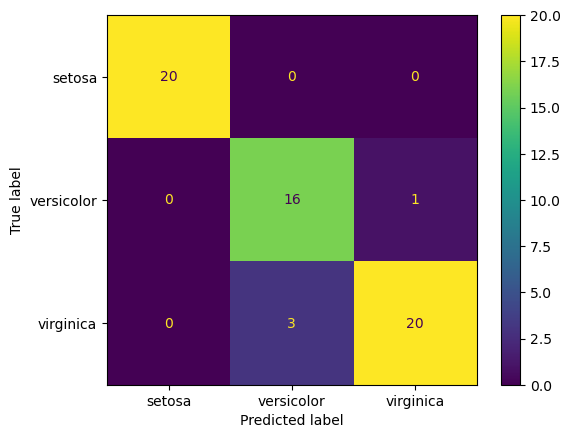

In [70]:
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay(cm, display_labels=iris.target_names).plot()
plt.show()

### The effect of the hyper-parameter $k$

Having tried out the classifier for a single value of $k$ we now turn to systematically test a range of $k$-values. 

In [74]:
error_rates_train = []
error_rates_test = []

max_k = 80
for k in range(1, max_k+1):
    knn = KnnClassifier(k).fit(x_train, y_train)
    error_rates_train.append(error_rate(y_train, knn.predict(x_train)))
    error_rates_test.append(error_rate(y_test, knn.predict(x_test)))

Let us again use `matplotlib` to plot the outcomes of this experiment in two views.

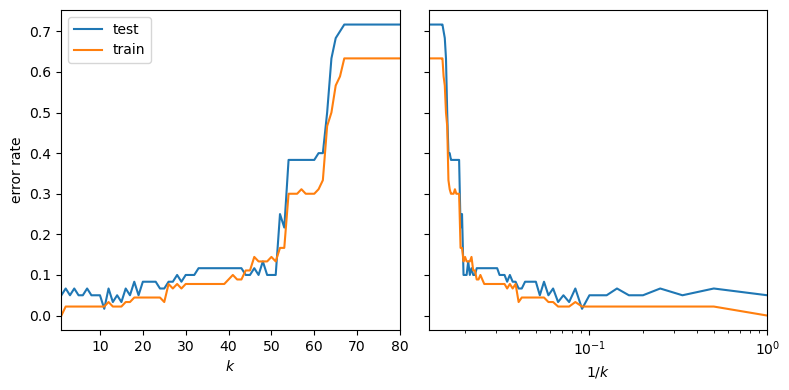

In [75]:
_, axs = plt.subplots(1, 2, figsize=(8, 4), tight_layout=True, sharey=True)
ks = np.arange(1, max_k+1)
axs[0].plot(ks, error_rates_test, label='test')
axs[0].plot(ks, error_rates_train, label='train')
axs[0].margins(x=0)
axs[0].set_ylabel('error rate')
axs[0].set_xlabel('$k$')
axs[0].legend()
axs[1].plot(1/ks, error_rates_test)
axs[1].plot(1/ks, error_rates_train)
axs[1].margins(x=0)
axs[1].set_xlabel('$1/k$')
axs[1].set_xscale('log')
plt.show()

## Discussion

#### Task F: Briefly discuss the following questions:

**Based on the above experiment, what is the best value for $k$?**

**What general trends can you discern about the effect of $k$?**

**Are there different trends for train and test error and can you relate them to the phenomena of overfitting and underfitting?**

**Would you get different results if you rerun the experiment with a different training/test split and is there a way to improve the experiment?**
	